In [1]:
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from torch import optim
import torch
import os

%load_ext autoreload
%autoreload 2
import env
import network
import player

BOARD_XSIZE=7
BOARD_YSIZE=6
DIMS=(BOARD_YSIZE,BOARD_XSIZE)

EPISODES_PER_AGENT = 100
TRAIN_EPOCHS = 500000
MODEL_SAVE_INTERVAL = 100
RANDOM_SEED = 42

SUMMARY_DIR = './summary'
MODEL_DIR = './models'

# create result directory
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)


use_cuda = torch.cuda.is_available()
torch.manual_seed(RANDOM_SEED)

cuda = torch.device("cuda")
cpu = torch.device("cpu")

if use_cuda:
    device = cuda
else:
    device = cpu


2023-06-09 17:32:43.486931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 17:32:44.372310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
actor = network.Actor(BOARD_XSIZE, BOARD_YSIZE).to(device)
critic = network.Critic(BOARD_XSIZE, BOARD_YSIZE).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=network.ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=network.CRITIC_LR)

# Get Writer
writer = SummaryWriter(log_dir=SUMMARY_DIR)

step=0

In [3]:
opponent_pool:list[player.Player] = [
    player.RandomPlayer(env.PLAYER2),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.1),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.3),
    player.MinimaxPlayer(env.PLAYER2, 2, 0.5),
]

rewards_vs: dict[str, list[float]] = {}

In [4]:
def play(actor:player.ActorPlayer, opponent: player.Player, actor_turn:bool) -> tuple[
    list[env.Observation],
    list[env.Action],
    list[env.Reward],
    list[env.Advantage],
    list[env.Reward],
]:
    e = env.Env(DIMS)

    s_t:list[env.Observation] = []
    a_t:list[env.Action] = []
    r_t:list[env.Reward] = []
    # play the game
    while not e.game_over():
        if actor_turn:
            obs, chosen_action, reward = actor.play(e)
            s_t += [obs]
            a_t += [chosen_action]
            r_t += [reward]
        else:
            opponent.play(e)

        # flip turn
        actor_turn = not actor_turn

    # compute advantage and value
    d_t = network.compute_advantage(actor.critic, s_t, r_t)
    v_t = network.compute_value(r_t)

    return s_t, a_t, r_t, d_t, v_t

In [5]:
# interrupt this cell when you're done training

for _ in range(TRAIN_EPOCHS):
    s_batch:list[env.Observation] = []
    a_batch:list[env.Action] = []
    p_batch:list[np.ndarray] = []
    d_batch:list[env.Advantage] = []
    v_batch:list[env.Value] = []
    
    # create actor player
    actor_player = player.ActorPlayer(actor, critic, step, env.PLAYER1)
    
    for _ in range(EPISODES_PER_AGENT):
        # pick a random opponent
        opponent_player = opponent_pool[np.random.randint(len(opponent_pool))]

        # whether we or our opponent goes first
        go_first = np.random.randint(2) == 0

        # play the game
        s_t, a_t, r_t, d_t, v_t = play(actor_player,opponent_player, go_first)

        # now update the minibatch
        s_batch += s_t
        a_batch += a_t
        d_batch += d_t
        v_batch += v_t

        # statistics
        opp_name = opponent_player.name()
        if opp_name in rewards_vs:
            rewards_vs[opp_name].append(float(v_t[-1]))
        else:
            rewards_vs[opp_name] = [float(v_t[-1])]

    actor_losses, critic_losses = network.train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        s_batch,
        a_batch,
        d_batch,
        v_batch
    )
    
    # pad actor_losses and critic_losses so that they're the same length
    max_len = max(len(actor_losses), len(critic_losses))
    actor_losses += [actor_losses[-1]]*(max_len - len(actor_losses))
    critic_losses += [critic_losses[-1]]*(max_len - len(critic_losses))

    for actor_loss, critic_loss in zip(actor_losses, critic_losses):
        writer.add_scalar('actor_loss', actor_loss, step)
        writer.add_scalar('critic_loss', critic_loss, step)

        for opponent_name, rewards in rewards_vs.items():
            if len(rewards) > 200:
                avg_reward = np.array(rewards).mean()
                writer.add_scalar(f'reward_against_{opponent_name}', avg_reward, step)
                rewards_vs[opponent_name] = []

        if step % MODEL_SAVE_INTERVAL == 0:
            # Save the neural net parameters to disk.
            torch.save(actor.state_dict(), f"{SUMMARY_DIR}/nn_model_ep_{step}_actor.ckpt")
            torch.save(critic.state_dict(), f"{SUMMARY_DIR}/nn_model_ep_{step}_critic.ckpt")
        
        step += 1

KeyboardInterrupt: 

In [ ]:
actor.load_state_dict(torch.load('./summary/nn_model_ep_500_actor.ckpt'))
#critic.load_state_dict(torch.load('./summary/nn_model_ep_1500_critic.ckpt'))

In [ ]:
e = env.Env(DIMS)

e.step(env.Action(1), env.PLAYER1)
e.step(env.Action(1), env.PLAYER1)
e.step(env.Action(1), env.PLAYER1)

e.step(env.Action(5), env.PLAYER2)
e.step(env.Action(5), env.PLAYER2)
e.step(env.Action(5), env.PLAYER2)



o = e.observe(1)
print(e.legal_mask())
env.print_obs(o)
print('0 1 2 3 4 5 6 7')
print(actor.forward(network.obs_to_tensor(o, device))[0])
print(critic.forward(network.obs_to_tensor(o, device))[0])

[ True  True  True  True  True  True  True]
              
              
              
  #       O   
  #       O   
  #       O   

0 1 2 3 4 5 6 7
tensor([0.0032, 0.9826, 0.0035, 0.0044, 0.0036, 0.0014, 0.0012],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.1882, device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# use this cell to observe some games from the network

s_tensor = network.obs_batch_to_tensor(s_batch, device)
critic_guesses = critic.forward(s_tensor).to(cpu).detach().numpy()
actor_guesses = actor.forward(s_tensor).to(cpu).detach().numpy()
for v, obs, critic_guess, actor_guess in zip(v_batch, s_batch, critic_guesses, actor_guesses):
    print("real_value", v)
    print("pred_value", float(critic_guess))
    print("actor_probs", np.array(actor_guess))
    env.print_obs(obs)
    print('0 1 2 3 4 5 6 7')

In [ ]:
# Now you try!
e = env.Env(DIMS)

actor_turn = True
opponent = player.ActorPlayer(actor, critic, step, env.PLAYER2)
human_player = player.HumanPlayer(env.PLAYER1)
# minmax player with depth 3 and no randomness

while not e.game_over():
    if actor_turn:
        obs, chosen_action, reward = human_player.play(e)
    else:
        opponent.play(e)
    # flip turn
    actor_turn = not actor_turn

if e.winner() == env.PLAYER1:
    print("You win!")
elif e.winner() == env.PLAYER2:
    print("You lose!")
else:
    print("Draw!")

### Testing the Value Network

In [ ]:
s_l = []
r_l = []
d_l = []
t_l = []
v_true_l = []
v_pred_l = []

for _ in range(200):
    # whether we or our opponent goes first
    go_first = np.random.randint(2) == 0
    # play the game
    s_t, _, r_t, d_t, v_t = play(actor_player,opponent_player, go_first)
    s_l += s_t
    r_l += r_t
    d_l += d_t
    t_l += [i for i in reversed(range(len(s_t)))]
    v_true_l += v_t
    v_pred_l += critic.forward(network.obs_batch_to_tensor(s_t, device)).to(cpu).detach().numpy().tolist()


s = np.array(s_l)
r = np.array(r_l)
d = np.array(d_l)
t = np.array(t_l)
v_true = np.array(v_true_l)
v_pred = np.array(v_pred_l)

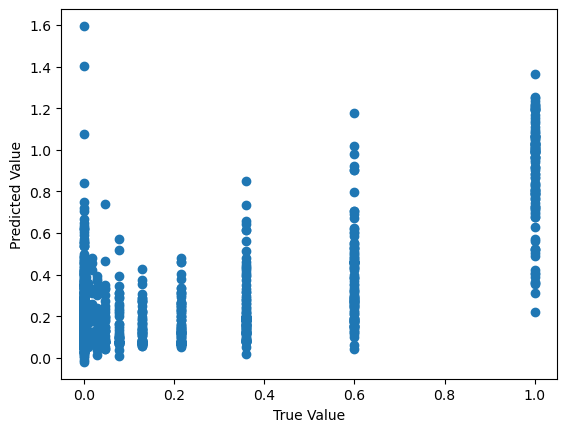

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(v_true, v_pred)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

In [2]:
plt.hist(v_true, bins=20, alpha=0.5, label='True')
plt.hist(v_pred, bins=40, alpha=0.5, label='Predicted')
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()

NameError: name 'plt' is not defined

In [3]:
plt.hist(d, bins=20, alpha=0.5)
plt.xlabel("Advantage")
plt.ylabel("Count")
plt.show()

NameError: name 'plt' is not defined

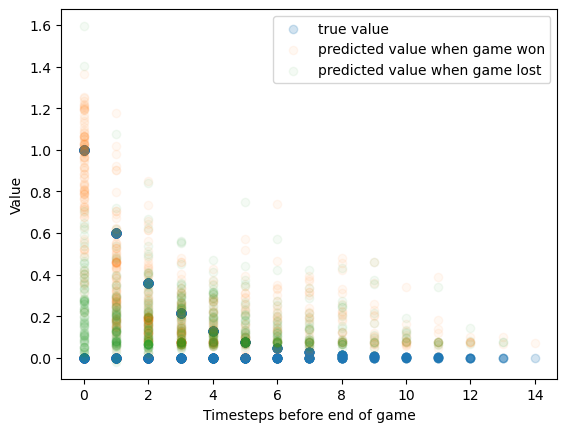

In [ ]:
plt.scatter(t, v_true, alpha=0.2, label='true value')
plt.scatter(t[v_true > 0], v_pred[v_true > 0], alpha=0.05, label='predicted value when game won')
plt.scatter(t[v_true == 0], v_pred[v_true == 0], alpha=0.05, label='predicted value when game lost')


plt.xlabel('Timesteps before end of game')
plt.ylabel('Value')
plt.legend()


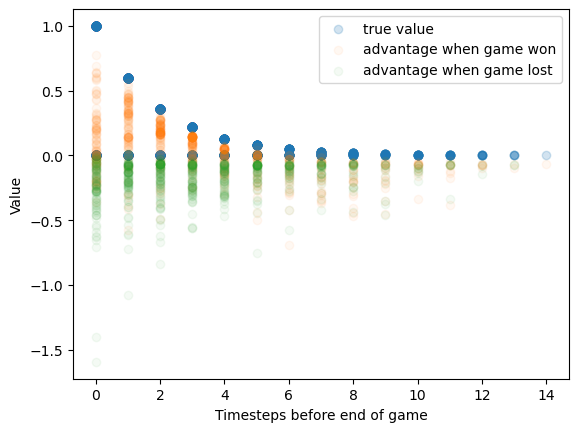

In [ ]:
plt.scatter(t, v_true, alpha=0.2, label='true value')
plt.scatter(t[v_true > 0], d[v_true > 0], alpha=0.05, label='advantage when game won')
plt.scatter(t[v_true == 0], d[v_true == 0], alpha=0.05, label='advantage when game lost')

plt.xlabel('Timesteps before end of game')
plt.ylabel('Value')
plt.legend()


In [6]:
v_true_variance = v_true.var()
print("Variance of true value", v_true_variance)
d_variance = np.array(d).var()
print("Variance of difference", d_variance)

NameError: name 'v_true' is not defined